In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import jax.numpy as jnp

from compressible_core import chemistry_utils, energy_models
from compressible_2d import (
    mesh_gmsh,
    equation_manager,
    equation_manager_types,
    equation_manager_utils,
    numerics_types,
)

In [7]:
# Load mesh and solution
repo_root = Path("/home/hhoechter/tum/jaxfluids_internship")
data_dir = repo_root / "data"

mesh = mesh_gmsh.read_gmsh(str(data_dir / "bluntedCone.msh"))
sol = jnp.load(str(repo_root / "experiments/blunt_cone_2d/solution_t10-6.npz"))
U_hist = sol["U"]
t_hist = sol["t"]
print(f"U shape: {U_hist.shape}, t: {t_hist}")

# Build a minimal equation manager for extract_primitives_from_U
species_names = ("N2",)
energy_cfg = energy_models.EnergyModelConfig(
    model="bird",
    include_electronic=False,
    data_path=str(data_dir / "air_5_bird_energy.json"),
)
species = chemistry_utils.load_species_table(
    species_names=species_names,
    general_data_path=str(data_dir / "species.json"),
    energy_model_config=energy_cfg,
)

boundary_tags = np.unique(mesh.boundary_tags)
tag_to_bc = {int(tag): {"type": "outflow"} for tag in boundary_tags if tag >= 0}

boundary_config = equation_manager_types.BoundaryConditionConfig2D(tag_to_bc=tag_to_bc)

numerics_config = numerics_types.NumericsConfig2D(
    dt=1e-9,
    cfl=0.4,
    dt_mode="fixed",
    integrator_scheme="rk2",
    spatial_scheme="first_order",
    flux_scheme="hllc",
    axisymmetric=True,
    clipping=numerics_types.ClippingConfig2D(),
)

eq_manager = equation_manager.build_equation_manager(
    mesh,
    species=species,
    collision_integrals=None,
    reactions=None,
    numerics_config=numerics_config,
    boundary_config=boundary_config,
    transport_model=equation_manager_types.TransportModelConfig(model="casseau"),
    casseau_transport=None,
)


U shape: (101, 241400, 5), t: [0.0000000e+00 5.0000001e-08 9.9999859e-08 1.4999991e-07 2.0000009e-07
 2.5000011e-07 2.9999958e-07 3.4999906e-07 3.9999853e-07 4.4999800e-07
 4.9999750e-07 5.4999697e-07 5.9999644e-07 6.4999591e-07 6.9999538e-07
 7.4999485e-07 7.9999433e-07 8.4999380e-07 8.9999327e-07 9.4999274e-07
 9.9999227e-07 1.0499917e-06 1.0999912e-06 1.1499907e-06 1.1999902e-06
 1.2499896e-06 1.2999891e-06 1.3499886e-06 1.3999880e-06 1.4499875e-06
 1.4999870e-06 1.5499865e-06 1.5999859e-06 1.6499854e-06 1.6999849e-06
 1.7499843e-06 1.7999838e-06 1.8499833e-06 1.8999827e-06 1.9499823e-06
 1.9999818e-06 2.0499813e-06 2.0999807e-06 2.1499802e-06 2.1999797e-06
 2.2499792e-06 2.2999786e-06 2.3499781e-06 2.3999776e-06 2.4499770e-06
 2.4999765e-06 2.5499760e-06 2.5999755e-06 2.6499749e-06 2.6999744e-06
 2.7499739e-06 2.7999733e-06 2.8499728e-06 2.8999723e-06 2.9499718e-06
 2.9999712e-06 3.0499707e-06 3.0999702e-06 3.1499696e-06 3.1999691e-06
 3.2499686e-06 3.2999681e-06 3.3499675e-06 3.39

In [13]:
jnp.all(jnp.isnan(U_hist[1:, :, :]))

Array(True, dtype=bool)

In [8]:
# Extract primitives at last timestep
U_last = U_hist[-1]
Y_s, rho, u, v, T, Tv, p = equation_manager_utils.extract_primitives_from_U(
    U_last, eq_manager
)

# Cell centroids for scatter positions
cx = np.array(mesh.cell_centroids[:, 0])  # r (radial)
cy = np.array(mesh.cell_centroids[:, 1])  # z (axial)

# Build triangulation from mesh cells for filled contour-like plots
triangles_i, triangles_j, triangles_k = [], [], []
for cell_nodes in mesh.cells:
    n = len(cell_nodes)
    if n == 3:
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[1])
        triangles_k.append(cell_nodes[2])
    elif n == 4:
        # Split quad into two triangles
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[1])
        triangles_k.append(cell_nodes[2])
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[2])
        triangles_k.append(cell_nodes[3])

triangles_i = np.array(triangles_i)
triangles_j = np.array(triangles_j)
triangles_k = np.array(triangles_k)

nodes_x = np.array(mesh.nodes[:, 0])
nodes_y = np.array(mesh.nodes[:, 1])

print(
    f"n_cells={len(mesh.cells)}, n_nodes={mesh.nodes.shape[0]}, n_triangles={len(triangles_i)}"
)
print(f"t_last = {float(t_hist[-1]):.3e} s")

n_cells=241400, n_nodes=241401, n_triangles=482798
t_last = 5.000e-06 s


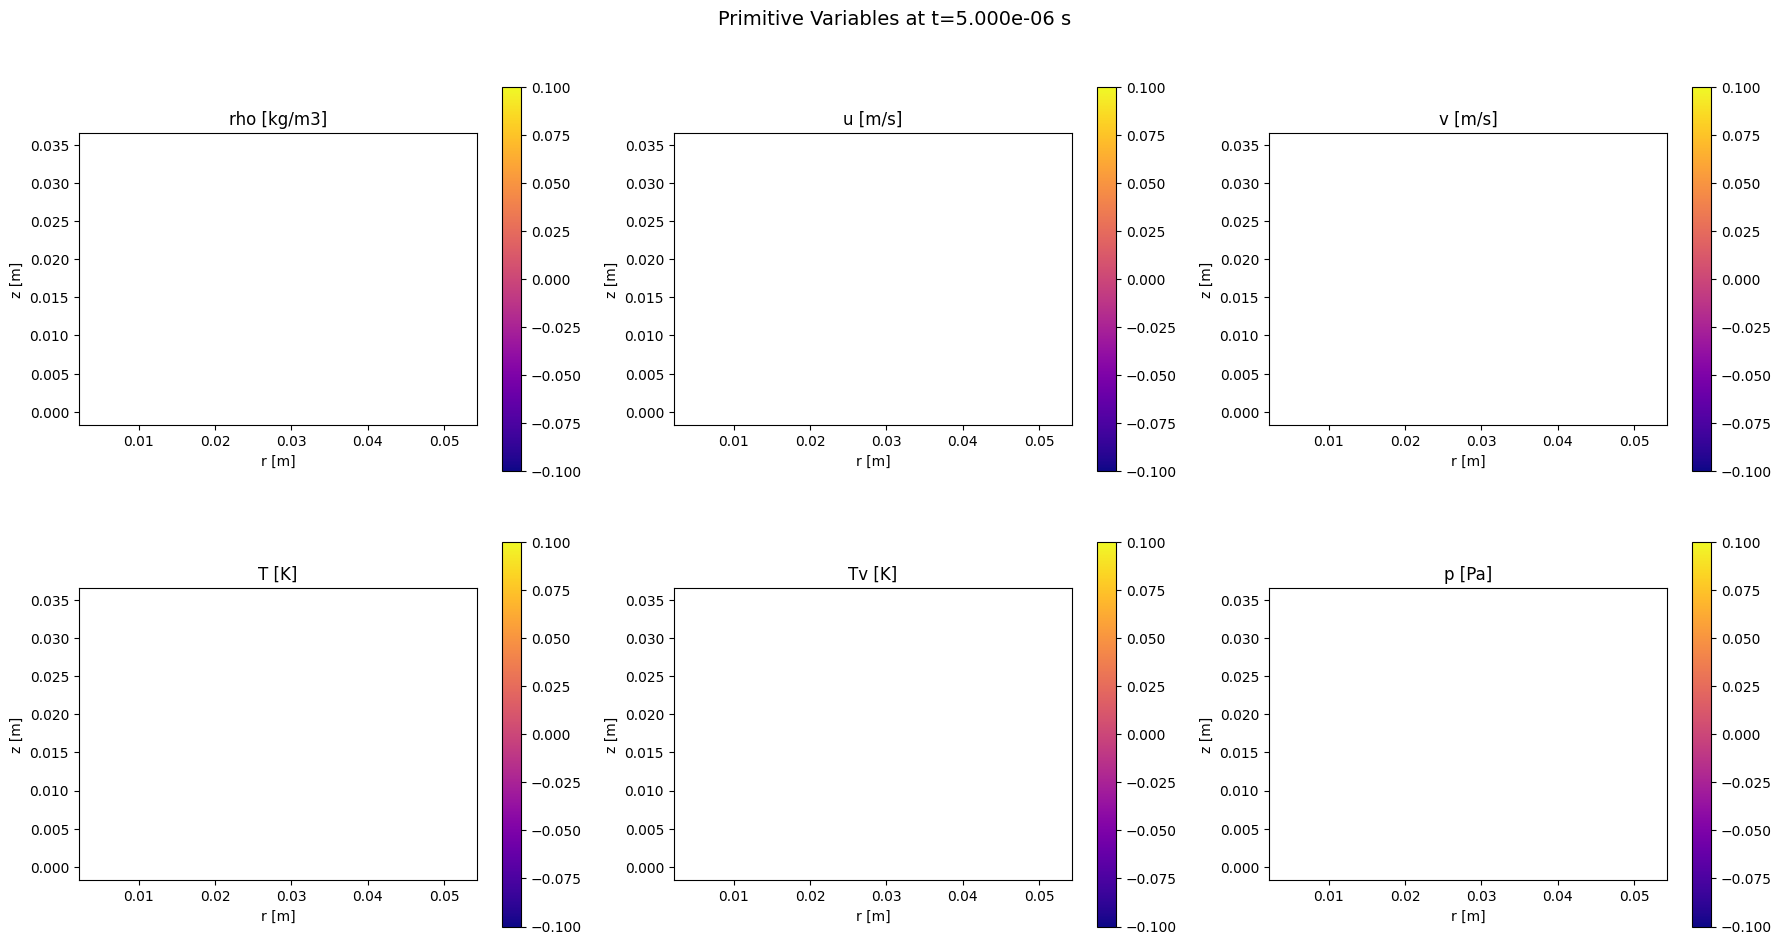

In [9]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Build a Triangulation object for matplotlib
# Each cell is a triangle (or quad split into 2 triangles)
triangles = np.column_stack([triangles_i, triangles_j, triangles_k])
triang = mtri.Triangulation(nodes_x, nodes_y, triangles)

primitives = {
    "rho [kg/m3]": np.array(rho),
    "u [m/s]": np.array(u),
    "v [m/s]": np.array(v),
    "T [K]": np.array(T),
    "Tv [K]": np.array(Tv),
    "p [Pa]": np.array(p),
}


# Map cell values to triangle values (for quads, both sub-triangles get the same value)
def cell_to_triangle_values(cell_values):
    """Map cell-centered values to per-triangle values (quads produce 2 triangles)."""
    tri_vals = []
    for cell_idx, cell_nodes in enumerate(mesh.cells):
        n = len(cell_nodes)
        tri_vals.append(cell_values[cell_idx])
        if n == 4:
            tri_vals.append(cell_values[cell_idx])
    return np.array(tri_vals)


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, values) in enumerate(primitives.items()):
    ax = axes[idx]
    tri_vals = cell_to_triangle_values(values)
    tc = ax.tripcolor(triang, facecolors=tri_vals, cmap="plasma", shading="flat")
    fig.colorbar(tc, ax=ax, shrink=0.8)
    ax.set_title(name)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("z [m]")
    ax.set_aspect("equal")

fig.suptitle(f"Primitive Variables at t={float(t_hist[-1]):.3e} s", fontsize=14)
plt.tight_layout()
plt.show()